In [2]:
import numpy as np

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sentence_transformers import SentenceTransformer

from data_preprocess import load_data, preprocess_data, plot_class_distribution
from modeling import prepare_dataloaders, train_model, predict_model, train_and_evaluate, MultiLabelClassifier, ReviewDataset
from metrics import calculate_auc, optimize_f1_thresholds, apply_thresholds, evaluate_model, predict_single_text


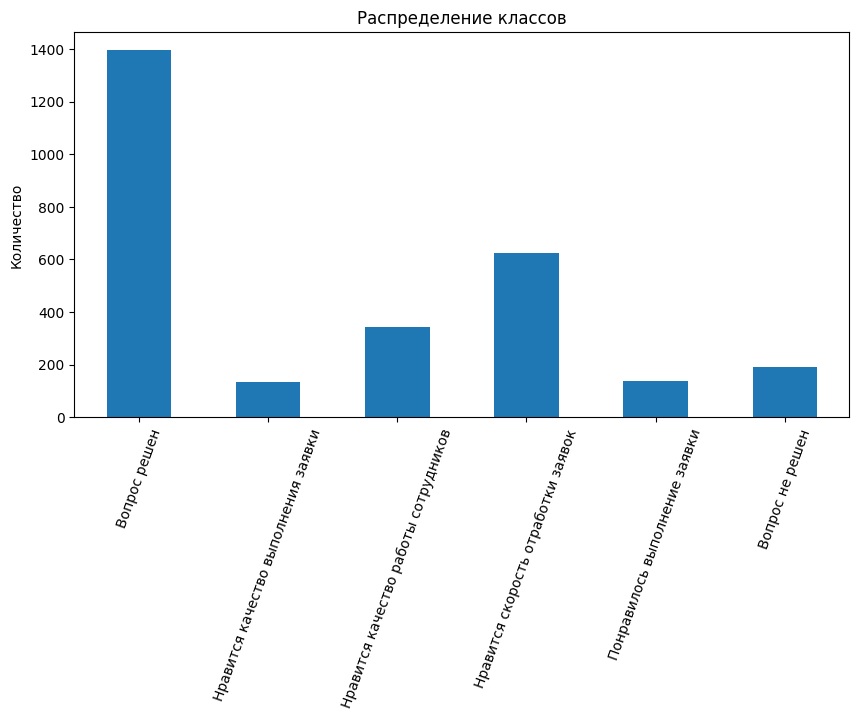

In [3]:
data = load_data('dirty_data.xlsx')
data_clean = preprocess_data(data)

plot_class_distribution(data_clean)

In [4]:
model_sbert = SentenceTransformer('cointegrated/rubert-tiny2')

# Названия колонок с метками
labels = [
    'Вопрос решен',
    'Вопрос не решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки'
]

In [5]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_per_fold = []

for fold, (train_idx, test_idx) in enumerate(mskf.split(data_clean, data_clean[labels])):
    print(f'\n--- Fold {fold+1} ---')
    train_df = data_clean.iloc[train_idx]
    test_df = data_clean.iloc[test_idx]

    train_loader, test_loader = prepare_dataloaders(train_df, test_df, model_sbert, labels)
    fold_results = train_and_evaluate(train_loader, test_loader, embedding_dim=312, num_labels=len(labels))
    results_per_fold.append(fold_results)

    model = train_model(train_loader, 312, len(labels))
    train_preds, train_labels = predict_model(model, train_loader)
    last_model = model
    last_thresholds, _ = optimize_f1_thresholds(train_labels, train_preds)  


--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


In [6]:
print('\n--- Средние результаты ---')
print('Train Micro AUC:', np.mean([r['train_micro_auc'] for r in results_per_fold]))
print('Test Micro AUC:', np.mean([r['test_micro_auc'] for r in results_per_fold]))
print('Train Micro F1:', np.mean([r['train_micro_f1'] for r in results_per_fold]))
print('Test Micro F1:', np.mean([r['test_micro_f1'] for r in results_per_fold]))


--- Средние результаты ---
Train Micro AUC: 0.972357927204001
Test Micro AUC: 0.9651191054344226
Train Micro F1: 0.876821860969945
Test Micro F1: 0.8531855710515203


In [7]:
new_text = "спасибо григорию, больше ничего не течет, очень оперативно"

predicted_tags, raw_scores = predict_single_text(new_text, last_model, model_sbert, last_thresholds, labels)

print(f"Текст: {new_text}")
print(f"Предсказанные теги: {predicted_tags}")
print(f"Raw scores: {raw_scores}")

Текст: спасибо григорию, больше ничего не течет, очень оперативно
Предсказанные теги: ['Вопрос решен', 'Нравится скорость отработки заявок']
Raw scores: [0.94053227 0.05583796 0.0705097  0.02200694 0.497687   0.09833606]
